# Libraries

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
from neuralsens import partial_derivatives as ns
from neuralsens.partial_derivatives import calculate_second_partial_derivatives_mlp,calculate_first_partial_derivatives_mlp
import torch.nn as nn
import torch.optim as optim
import torch
import sys
import os
from torch.autograd.functional import hessian, jacobian
import importlib
sys.path.append('../Scripts')

from DNN import DNN
import utilities_lipschitz
importlib.reload(utilities_lipschitz)


<module 'utilities_lipschitz' from '/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/PhD/Codigo/NNMonotonic/Notebooks/../Scripts/utilities_lipschitz.py'>

# Dataset Generation

In [2]:

# Generate synthetic dataset
np.random.seed(0)
n_samples = 1000

# input variables
X1 = np.random.rand(n_samples)
X2 = np.random.rand(n_samples)
X3 = np.random.rand(n_samples)
X4 = np.random.rand(n_samples)
X5 = np.random.rand(n_samples)

# Interaction terms
interaction1 = X1 * X2
interaction2 = - 5 * X3 * X4

# Output variable with some noise
y = 3 * X1 + 2 * X2 + 5 * interaction1 + 2 * interaction2 + 0.1 * np.random.randn(n_samples)

# Combine input variables into a single array
X = np.column_stack((X1, X2, X3, X4, X5))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define input names for neuralsens
input_names = ['x' + str(i + 1) for i in range(X.shape[1])]

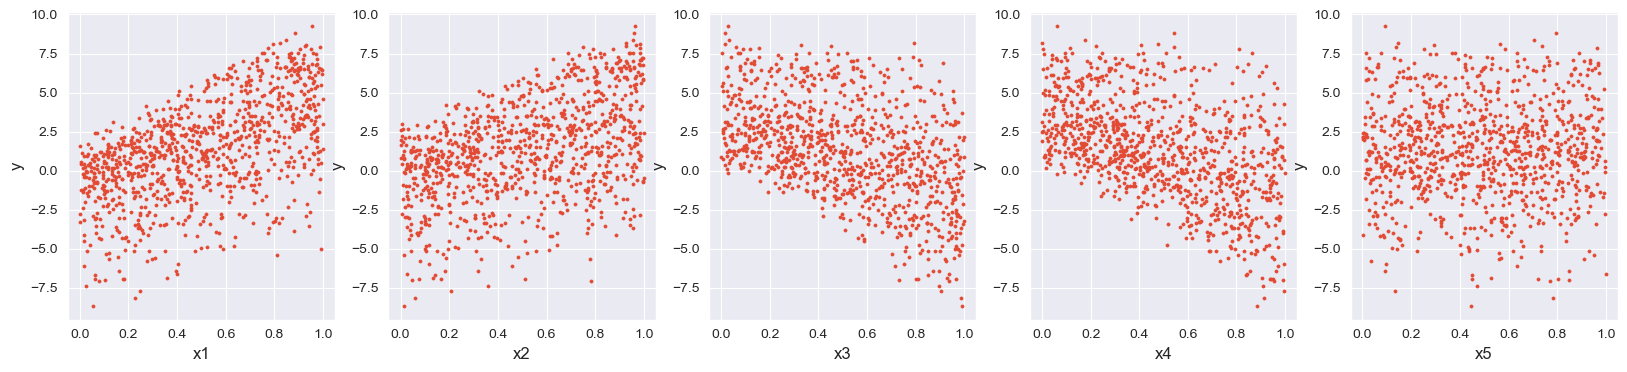

In [3]:
### PLOT INPUT AND OUTPUT VARIABLES ###
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Plot input variables
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].scatter(X[:, i], y, s=5)
    axs[i].set_xlabel(input_names[i])
    axs[i].set_ylabel('y')
plt.show()


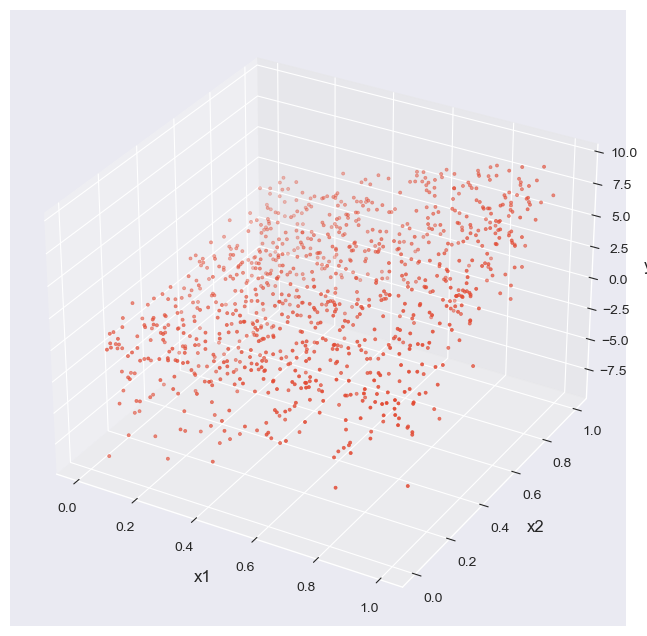

In [4]:
### PLOT IN 3D INPPUT X1,X2, AND OUTPUT Y ###
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, s=5)
ax.set_xlabel(input_names[0])
ax.set_ylabel(input_names[1])
ax.set_zlabel('y')
plt.show()


# Scikit example

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


# Initialize and train the MLP Regressor
mlp = MLPRegressor(solver='lbfgs', # Update function
                        activation='logistic', # Logistic sigmoid activation function
                        learning_rate_init=0.01, # Initial learning rate
                        learning_rate='adaptive', # Type of learning rate used in training
                        hidden_layer_sizes=6,
                        alpha=0.0001,
                        # max_iter=250, # Maximum number of iterations
                        max_iter=5000,
                        batch_size=20, # Size of batch when training
                        tol=1e-4, # Tolerance for the optimization
                        validation_fraction=0.0, # Percentage of samples used for validation
                        n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                        random_state=150)
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


In [ ]:
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity', mlp.get_params()['activation'], mlp.out_activation_]

X_ns = pd.DataFrame(X_train, columns=input_names)
y_ns = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [ ]:
jac_mlp = ns.jacobian_mlp(wts, bias, actfunc, X_ns, y_ns) # jacobian
hes_mlp = ns.hessian_mlp(wts, bias, actfunc, X_ns, y_ns) # hessian

In [ ]:
jac_mlp.plot()

In [ ]:
hes_mlp.plot()

# Torch example

#### DERIVATIVES

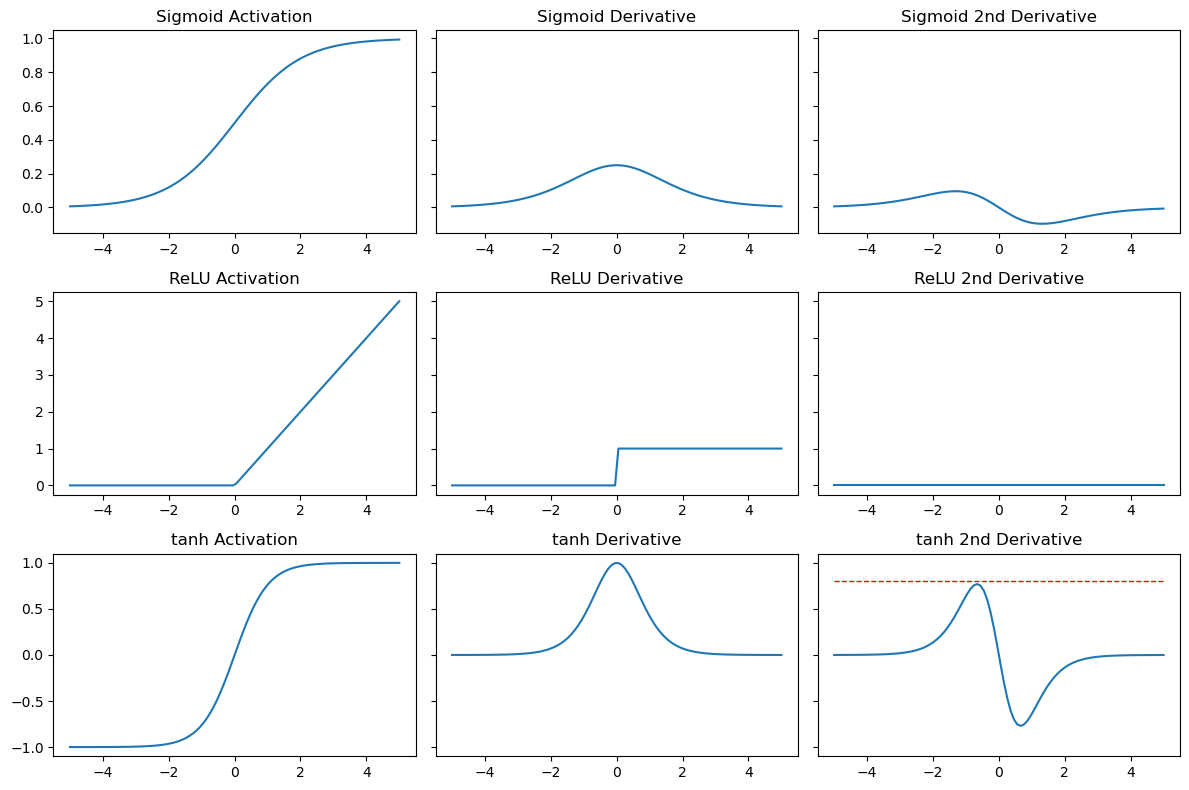

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid activation function and its derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def sigmoid_second_derivative(x):
    return sigmoid_derivative(x) *  (1 - 2 * sigmoid(x))

# Define the ReLU activation function and its derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def relu_second_derivative(x):
    return np.zeros_like(x)

# Define the tanh activation function and its derivatives
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def tanh_second_derivative(x):
    return -2 * np.tanh(x) * (1 - np.tanh(x)**2)

# Generate x values
x = np.linspace(-5, 5, 100)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8),sharey='row')

# Plot for sigmoid
axes[0, 0].set_title("Sigmoid Activation")
axes[0, 0].plot(x, sigmoid(x))
axes[0, 1].set_title("Sigmoid Derivative")
axes[0, 1].plot(x, sigmoid_derivative(x))
axes[0, 2].set_title("Sigmoid 2nd Derivative")
axes[0, 2].plot(x, sigmoid_second_derivative(x))

# Plot for ReLU
axes[1, 0].set_title("ReLU Activation")
axes[1, 0].plot(x, relu(x))
axes[1, 1].set_title("ReLU Derivative")
axes[1, 1].plot(x, relu_derivative(x))
axes[1, 2].set_title("ReLU 2nd Derivative")
axes[1, 2].plot(x, relu_second_derivative(x))

# Plot for tanh
axes[2, 0].set_title("tanh Activation")
axes[2, 0].plot(x, tanh(x))
axes[2, 1].set_title("tanh Derivative")
axes[2, 1].plot(x, tanh_derivative(x))
axes[2, 2].set_title("tanh 2nd Derivative")
axes[2, 2].plot(x, tanh_second_derivative(x))
## plot a horizontal line in y=0.8
axes[2,2].plot(x, np.zeros_like(x) + 0.8, 'r--', linewidth=1)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


## MLP Example

### DATA GENERATION

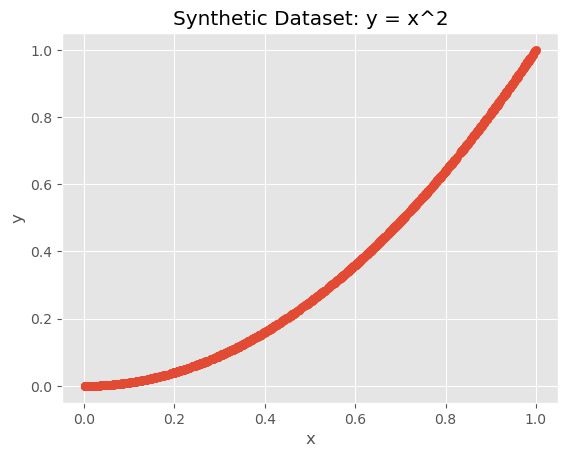

In [6]:
## Generate a one dimensional torch dataset y=x^2

# Set a random seed for reproducibility
torch.manual_seed(42)

# Define the dataset size
num_samples = 1000

# Generate random values for x
x = torch.rand(num_samples)

# Compute y based on y = x^2
y = x**2

# Reshape x and y to have a single dimension
x = x.view(-1, 1)
y = y.view(-1, 1)

#x.requires_grad = True

# Visualize the dataset
plt.scatter(x.detach().numpy(), y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Dataset: y = x^2')
plt.show()


In [11]:
## Generate two dimensional dataset y=x1^2+x2^2

# Set a random seed for reproducibility
torch.manual_seed(42)

# Define the dataset size
num_samples = 1000

# Generate random values for x1 and x2 in the interval [0, 1)
x1 = torch.rand(num_samples)
x2 = torch.rand(num_samples)

# Compute y based on y = x1^2 + x2^2
y = x1**2 + x2**2

# Reshape x1, x2, and y to have a single dimension
x1 = x1.view(-1, 1)
x2 = x2.view(-1, 1)
y = y.view(-1, 1)

# Visualize the datasets
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x1.detach().numpy().flatten(), y=x2.detach().numpy().flatten(), z=y.detach().numpy().flatten(), mode='markers', marker=dict(size=5))])
fig.update_layout(scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='y', aspectmode='cube'), height=500, width=1400)
fig.show()



### MODELLING

In [12]:
## Compute the jacobian using the chain rule
def batch_hessian(model, input):
    """Calcula el jacobiano para todas las muetras de un batch. El resultado es 
    un tensor de tamaño (n_outputs,batch_size,n_inputs) de manera que los 
    siguientes vectores
    ...
    """
    f_sum = lambda x: torch.sum(model(x), axis=0)
    return hessian(f_sum, input, create_graph=True) 

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=2, out_features=2, bias=True)
    (activation_0): Sigmoid()
    (layer_1): Linear(in_features=2, out_features=1, bias=True)
  )
)
Epoch [100/10000], Loss: 1.7558
Epoch [200/10000], Loss: 1.2825
Epoch [300/10000], Loss: 0.9214
Epoch [400/10000], Loss: 0.6482
Epoch [500/10000], Loss: 0.4541
Epoch [600/10000], Loss: 0.3255
Epoch [700/10000], Loss: 0.2457
Epoch [800/10000], Loss: 0.1994
Epoch [900/10000], Loss: 0.1741
Epoch [1000/10000], Loss: 0.1609
Epoch [1100/10000], Loss: 0.1540
Epoch [1200/10000], Loss: 0.1502
Epoch [1300/10000], Loss: 0.1477
Epoch [1400/10000], Loss: 0.1456
Epoch [1500/10000], Loss: 0.1435
Epoch [1600/10000], Loss: 0.1413
Epoch [1700/10000], Loss: 0.1390
Epoch [1800/10000], Loss: 0.1364
Epoch [1900/10000], Loss: 0.1336
Epoch [2000/10000], Loss: 0.1306
Epoch [2100/10000], Loss: 0.1273
Epoch [2200/10000], Loss: 0.1237
Epoch [2300/10000], Loss: 0.1199
Epoch [2400/10000], Loss: 0.1158
Epoch [2500/10000], Loss

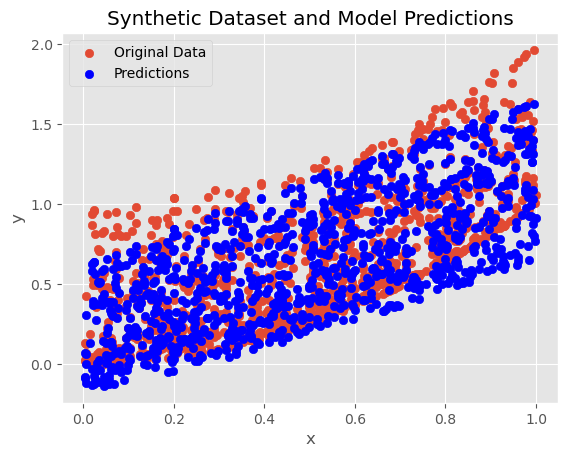

In [13]:
#### TRAINING

torch.manual_seed(2023)

### MODEL DEFINITION ###
layers = [2,2,1]
actfunc = ['sigmoid']
model = DNN(layers,activations=actfunc)
actfunc.insert(0,'identity')
actfunc.append('identity')
print(model)

learning_rate = 0.001
num_epochs = 10000

x = torch.cat((x1,x2),1)
# Loss function (MSE: Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer (SGD: Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay=0.0)
#Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x)
    
    # Calculate the loss
    loss = criterion(outputs, y)

    ##Compute the hessian of the loss function
    #hessiano = batch_hessian(model, x)
    #hessian_loss = hessiano.mean()

    #total_loss = loss+hessian_loss
    total_loss = loss
    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
model.eval()
with torch.no_grad():
    predicted = model(x)

# Visualize the original data and the model's predictions
plt.scatter(x[:,1], y, label='Original Data')
plt.scatter(x[:,1], predicted.detach().numpy(), color='blue', label='Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Dataset and Model Predictions')
plt.legend()
plt.show()

In [14]:
fig = go.Figure(data=[go.Scatter3d(x=x1.detach().numpy().flatten(), y=x2.detach().numpy().flatten(), z=y.detach().numpy().flatten(), mode='markers', name='True', marker=dict(size=3))])
fig.add_trace(go.Scatter3d(x=x1.detach().numpy().flatten(), y=x2.detach().numpy().flatten(), z=predicted.detach().numpy().flatten(), mode='markers', name='Predicted', marker=dict(size=3)))
fig.update_layout(scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='y', aspectmode='cube'), height=500, width=1000)
fig.show()


In [15]:
### Extract weights and biases from the model
parameters = dict(model.state_dict())
parameters

{'layers.layer_0.weight': tensor([[ 1.4955,  1.5298],
         [-0.7887, -0.8206]]),
 'layers.layer_0.bias': tensor([-1.9339,  0.7046]),
 'layers.layer_1.weight': tensor([[ 2.2160, -1.1321]]),
 'layers.layer_1.bias': tensor([0.3072])}

In [16]:
## Extract weights and biases from the model
weights = []
biases = []
for key, value in parameters.items():
    if 'weight' in key:
        weights.append(value.T)
    elif 'bias' in key:
        biases.append(value)
print('biases', biases)
print('weights', weights)

biases [tensor([-1.9339,  0.7046]), tensor([0.3072])]
weights [tensor([[ 1.4955, -0.7887],
        [ 1.5298, -0.8206]]), tensor([[ 2.2160],
        [-1.1321]])]


In [17]:
### FIRTS PARTIAL DERIVATIVES
W, Z, O, D, D_accum, counter, mlpstr = calculate_first_partial_derivatives_mlp(weights, biases, actfunc, x[1].view(-1,2), y[1].view(-1,1),sens_end_layer=len(actfunc))

Returns:

W (list of numpy arrays or torch tensors): List of weight matrices for each layer of the MLP.

Z (list of numpy arrays or torch tensors): List of input values for each layer of the MLP.

O (list of numpy arrays or torch tensors): List of output values for each layer of the MLP.

D (list of numpy arrays or torch tensors): List of derivatives for each layer of the MLP.

D_accum (list of numpy arrays or torch tensors): List of accumulated sensitivity values for each calculated layer.

counter (int): Number of layers between sens_origin_layer and sens_end_layer. It serves to know the final derivatives to return in the jacobian_mlp.

mlpstr (list of integer): Structure of the mlp model.


In [18]:
parameters

{'layers.layer_0.weight': tensor([[ 1.4955,  1.5298],
         [-0.7887, -0.8206]]),
 'layers.layer_0.bias': tensor([-1.9339,  0.7046]),
 'layers.layer_1.weight': tensor([[ 2.2160, -1.1321]]),
 'layers.layer_1.bias': tensor([0.3072])}

In [19]:
D_accum

[array([[[1, 0],
         [0, 1]]]),
 array([[[ 0.37184589, -0.19433757],
         [ 0.38036199, -0.20219709]]]),
 array([[[1.04402745],
         [1.07179692]]])]

In [20]:
#### WEIGHTS AND BIASES
W

[array([[1., 0.],
        [0., 1.]]),
 array([[-1.9339094 ,  0.70456564],
        [ 1.4955457 , -0.78869414],
        [ 1.5297971 , -0.820591  ]], dtype=float32),
 array([[ 0.30722266],
        [ 2.2160392 ],
        [-1.132063  ]], dtype=float32)]

**ACOTACIÓN DEL HESSIANO $H_0^K$**

**PASO 1**: Acotación de $H_0^1$

En primer lugar, se tiene que $H_0^1$ viene dado por:
$$H_0^1 = W^1 \otimes_i W^1 \otimes_j H_1^1$$
Considerando que se quiere la acotación parcial con respecto a la variable i-ésima, es por ello que no estamos interesados en $H_0^1$ sino en $\tilde{H}_0^1=(0,0,..,1(i),...0)\otimes_iH_0^1$ 
$$\tilde{H}_0^1 = \tilde{W}^1 \otimes_i W^1 \otimes_j H_1^1 = \left(\tilde{W}^1 \otimes_i H_1^1\right)(W^1)^t $$
por lo tanto:
$$\lVert H_0^1 \rVert \leq \lVert \tilde{W}^1 \otimes_i H_1^1 \rVert * \lVert W^1 \rVert $$
de donde se deduce que $\lVert \tilde{W}^1 \otimes_i H_1^1 \rVert \leq max|a_k^1|*\lVert W_{1j}^1 \rVert$ where $ W_{1j}^1$ corresponds to the ith-row of $W^1$ y por lo tanto:
$$\lVert H_0^1 \rVert \leq max|a_k^1|*\lVert W_{1j}^1 \rVert * \lVert W^1 \rVert $$

**PASO 2**: Acotación de $H_0^2$

En primer lugar, se tiene que $H_0^1$ viene dado por:
$$\tilde{H_0^2} = \left(\tilde{J}_0^1*W^2\right) \otimes_i \left(J_0^1*W^2\right)  \otimes_j H_2^2 + \tilde{H}_0^1*W^2*J_2^2 = \left(\left(\tilde{J}_0^1*W^2\right) \otimes_i H_2^2\right)*\left(J_0^1*W^2\right)^t + \tilde{H}_0^1*W^2*J_2^2 $$
Por lo tanto, acotando por parte se tiene que
$$\bigg\lVert \left(\tilde{J}_0^1*W^2 \right) \otimes_i H_2^2\bigg\rVert \leq max|a_k^2|*\lVert W_{1j}^1\rVert * \lVert W^2\rVert$$
$$ \lVert J_0^1*W^2\rVert \leq \lVert W^1\rVert * \lVert W^2\rVert$$
ya que $ J_0^1 = J_0^0*W^1*J_1^1$
y por lo tanto:
$$\lVert H_0^2 \rVert \leq max|a_k^2|*\lVert W_{1j}^1\rVert * \lVert W^1\rVert*\lVert W^2\rVert ^2 + \lVert H_0^1 \rVert * \lVert W^2 \rVert $$

**PASO 3**: Acotación de $H_0^l$
$$\lVert H_0^l \rVert \leq max|a_k^l|*\lVert W_{1j}^1\rVert * \lVert W^1\rVert*\lVert W^2\rVert ^2*...*\lVert W^l\rVert ^2 + \lVert H_0^{l-1} \rVert * \lVert W^l \rVert $$



In [41]:
def hessian_bound_2_inputs_2_hidden(W,actfunc,partial_monotonic_variable,n_variables):
    ## Compute the hessian bound for a 2 inputs 2 hidden layer network
    input_vector = [0] * n_variables
    input_vector[partial_monotonic_variable] = 1
    if actfunc[0]=='sigmoid' and actfunc[1]=='sigmoid':
        norm = np.linalg.norm(input_vector @ W[1][1:, :], ord=2) * np.linalg.norm(W[2][1:, :], ord=2) * np.linalg.norm(W[1][1:, :], ord=2) * np.abs(0.25) * (np.linalg.norm(W[2][1:, :], ord=2) + 1)
    elif actfunc[0]=='sigmoid' and actfunc[1]=='identity':
        norm = np.linalg.norm(input_vector @ W[1][1:, :], ord=2) * np.linalg.norm(W[2][1:, :], ord=2) * np.linalg.norm(W[1][1:, :], ord=2) * np.abs(0.25)
    else:
        print('Si no es una sigmoid no se puede usar la acotación 0.25')
    return norm

def hessian_bound(W,actfunc,partial_monotonic_variable,n_variables):
    """_summary_
    La idea es generar un algoritmo recursivo de modo que si la red neuronal tiene k capas, entonces se comience calculando el hessiano acotado
    H_0_1, luego el hessiano acotado H_0_2, y así sucesivamente hasta llegar a H_0_k.
    Args:
        W (_type_): list of numpy arrays with the weights (W[i][1:,:]) and the biases (W[i][0,:]) of the network
    """
    hessian_boud =[]
    ## First compute H_0^1
    ## Remember that ||H_0_1|| <= max|a_k_1|*||W_1_1||*||W_1|| 
    # where W_1_1 is the first row of the first layer of weights and a_k_1 is the maximum possible value of the second derivative of the activation function of the first layer
    input_vector = [0] * n_variables
    input_vector[partial_monotonic_variable] = 1
    if actfunc[1]=='sigmoid':
        a_1 = 0.25
    else:
        a_1 = 1
    ## W_1j^1 * W_1
    weights_multiplication = np.linalg.norm(input_vector @ W[1][1:, :], ord=2) * np.linalg.norm(W[1][1:, :], ord=2)
    H_0_1 = a_1*weights_multiplication
    hessian_boud.append(H_0_1)
    
    ## In general, H_0_k can be bounded following the next equation
    # H_0_k <= max|a_k|*||W_1_1||*||W_1||*(||W_2||^2)*...*(||W_{k+1}||^2) + H_0_{k-1}*||W_k||
    for k in range(2,len(actfunc)):
        if actfunc[k]=='sigmoid':
            a_k = 0.25
        elif actfunc[k]=='identity': #### HAY QUE REVISAR QUE ESTA CONDICIÓN ESTÉ CORRECTA
            a_k = 0
        weights_multiplication = weights_multiplication * np.linalg.norm(W[k][1:, :], ord=2)**2
        H_0_k = a_k*weights_multiplication + hessian_boud[-1]*np.linalg.norm(W[k][1:, :], ord=2)
        hessian_boud.append(H_0_k)
    return hessian_boud

In [42]:
actfunc

['identity', 'sigmoid', 'identity']

In [43]:
hessian_bound(W,actfunc,0,2)

[1.0242995981498646, 2.548921072926219]

**ESTRUCTURA DE LAS DERIVADAS**


$$ W[i][0,:] =  Biases$$
$$ W[i][j,:] = \text{Weights multiplying output of neuron j}$$
$$ W[i][j,k] = \text{Weights multiplying output of neuron j going to neuron k}$$
$$ D[i] = J^i_i$$
$$ D2[i] = H^i_i$$
$$ Dacum[i] = J^i_0$$
$$ H[i] = H^i_0$$

In [142]:
### JACOBIAN COMPUTED FOLLOWING THE CHAIN RULE  
def jacobian_neuralsens(D,W):
    output = np.matmul(D[0],np.matmul(W[1][1:],D[1]))
    for i in range(len(W)-2):
        output = np.matmul(output,np.matmul(W[i+2][1:],D[i+2]))
    return output
jacobian_neuralsens(D, W)

array([[[0.76450224],
        [0.77416228]]])

In [143]:
3## COMPROBACIÓN DE LA JACOBIANA
D_accum

[array([[[1, 0],
         [0, 1]]]),
 array([[[ 0.25040479, -0.20219495],
         [ 0.25381767, -0.2044176 ]]]),
 array([[[0.76450224],
         [0.77416228]]])]

In [145]:
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, actfunc, x[0].view(-1,2), y[0].view(-1,1),sens_end_layer=len(actfunc))

Returns:

1) W (list of numpy arrays or torch tensors): List of weight matrices for each layer of the MLP.

2) Z (list of numpy arrays or torch tensors): List of input values for each layer of the MLP.

3) O (list of numpy arrays or torch tensors): List of output values for each layer of the MLP.

4) D (list of numpy arrays or torch tensors): List of derivatives for each layer of the MLP.

5) D2 (list of numpy arrays or torch tensors): List of second derivatives for each layer of the MLP.

6) D_accum (list of numpy arrays or torch tensors): List of accumulated sensitivity values for each calculated layer.

7) Q (list of numpy arrays or torch tensors): List of accumulated second partial derivatives of the input of the layer with respect to the inputs of the model.

8) H (list of numpy arrays or torch tensors): List of accumulated second partial derivatives of the output of the layer with respect to the inputs of the model.

9) counter (int): Number of layers between sens_origin_layer and sens_end_layer. It serves to know the final derivatives to return in the jacobian_mlp.
10)  mlpstr (list of integer): Structure of the mlp model.

In [146]:
### SECOND PARTIAL DERIVATIVES
H

[array([[[[0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0]]]]),
 array([[[[-0.10418615,  0.06684315],
          [-0.10560614,  0.06757793]],
 
         [[-0.10560614,  0.06757793],
          [-0.10704549,  0.06832079]]]]),
 array([[[[-0.29345885],
          [-0.29720739]],
 
         [[-0.29720739],
          [-0.30100425]]]])]

# Gradient Bounding

In [40]:
#### BOUNDING THE JACOBIAN USING THE NORM OF THE GRADIENTS AND THE WEIGHTS OF THE NETWORK ####
from numpy.linalg import norm
def jacobian_neuralsens(D,W):
    ### COMPUTE THE JACOBIAN FOLLOWING THE RECURSIVE FORMULA -> J^k_0 = J^{k-1}_0*W^k*D^k_k
    output = np.matmul(D[0],np.matmul(W[1][1:],D[1]))
    for i in range(len(W)-2):
        output = np.matmul(output,np.matmul(W[i+2][1:],D[i+2]))
    return output


## Generate list of bounds
D_bounded=utilities_lipschitz.generate_activations_bounds(D,W,'sigmoid')

## Compute the jacobian using the bounds
print(utilities_lipschitz.jacobian_bounding(D_bounded,W))

## Compute the jacobian using the chain rule
def batch_hessian(model, input):
    """Calcula el jacobiano para todas las muetras de un batch. El resultado es 
    un tensor de tamaño (n_outputs,batch_size,n_inputs) de manera que los 
    siguientes vectores
    ...
    """
    f_sum = lambda x: torch.sum(model(x), axis=0)
    return hessian(f_sum, input, create_graph=True) 

def batch_jacobian(model, input):
    """Calcula el jacobiano para todas las muetras de un batch. El resultado es 
    un tensor de tamaño (n_outputs,batch_size,n_inputs) de manera que los 
    siguientes vectores
    ...
    """
    f_sum = lambda x: torch.sum(model(x), axis=0)
    return jacobian(f_sum, input, create_graph=True)

# compute the hessian
hessian_matrix = batch_jacobian(model, x[0].view(-1,1))

# Calculate the local Lipschitz constant as the maximum norm of the gradient
jacobian_auto = torch.norm(hessian_matrix, p=2.0)
print(jacobian_auto)

15.956071837647436
tensor(1.1396, grad_fn=<NormBackward1>)


In [41]:
## Generate list of bounds
H_bounded=utilities_lipschitz.generate_hessian_bounds(H,W,'sigmoid')

## Compute the hessian using the bounds
print(utilities_lipschitz.hessian_bounding(H_bounded,D_bounded,W))

# compute the hessian
hessian_matrix = batch_hessian(model, x[0].view(-1,1))

# Calculate the local Lipschitz constant as the maximum norm of the gradient
global_lipschitz_constant = torch.norm(hessian_matrix, p=2.0)
print(global_lipschitz_constant)

84.2673411895291
tensor(0.2946, grad_fn=<NormBackward1>)


## Sensitivity Analysis

In [ ]:
import torch
import torch.nn as nn
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cpu')
device

In [ ]:
# Create torch tensor and send data to device
X_train_tch = torch.FloatTensor(X_train).requires_grad_(True).to(device)
X_test_tch = torch.FloatTensor(X_test).requires_grad_(True).to(device)
y_train_tch = torch.FloatTensor(y_train).squeeze().to(device)
y_test_tch = torch.FloatTensor(y_test).squeeze().to(device)

In [ ]:
# Define custom MLP class
class MLP(nn.Sequential):
    def __init__(self,
                n_inputs: int,                  # int: Number of input variables
                regression: bool,               # bool: flag to indicate if model is for regression (True) or classification (False)
                n_outputs: int = 1,             # int: Number of output variables
                activation_function=nn.Sigmoid, # nn.function: Activation function for hidden neurons
                n_hidden:list = [10]            # list[int]: Neurons in hidden layer of mlp
                ):
        # Store layers to initiate sequential neural network
        layers = []
        first = True
        for idx, neurons in enumerate(n_hidden):
            if first:
                layers += [nn.Linear(n_inputs, neurons)]
                first = False
            else:
                layers += [nn.Linear(n_hidden[idx-1], neurons)]
            layers += [activation_function()]
        layers += [nn.Linear(n_hidden[idx], n_outputs)]
        if not regression:
            layers += [nn.Sigmoid()]
        super(MLP, self).__init__(*layers)

In [ ]:
# Create torch model and send data to device
hidden_neurons = [20]
model = MLP(n_inputs=X_train_tch.size(1),
            n_outputs=1,
            n_hidden=hidden_neurons,
            regression=True, 
            activation_function=nn.Sigmoid)
model = model.to(device)

In [ ]:
# Define error loss and optimizer
criterion = torch.nn.MSELoss()
eps = 1e-6
lr = 0.3
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=lr,
                            eps=eps,
                            weight_decay=weight_decay)

In [ ]:
# Calculate test loss before training
model.eval()
y_pred = model(X_test_tch)
before_train = criterion(y_pred.squeeze().to(device), y_test_tch)
print('Test loss before training' , before_train.item())  

In [ ]:
model.train()
max_epoch = 800
loss = before_train
val_loss = before_train

for epoch in range(max_epoch):
    optimizer.zero_grad() # Reset the gradient
    
    # Forward pass
    y_pred = model(X_train_tch)
        
    # Compute Loss
    loss = criterion(y_pred.squeeze().to(device), y_train_tch)
    y_pred = model(X_test_tch)
    val_loss = criterion(y_pred.squeeze().to(device), y_test_tch)
    print(f'Epoch {epoch}: train loss: {loss.item()} test loss: {val_loss.item()}')
    
    # Backward pass
    loss.backward()
    optimizer.step()

In [ ]:
# Calculate test loss after training
model.eval()
y_pred = model(X_test_tch)
after_train = criterion(y_pred.squeeze().to(device), y_test_tch)
print('Test loss after training' , after_train.item())  

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

print('training r2:',r2_score(model(X_train_tch).squeeze().to(device).detach().numpy(), y_train))
print('test r2:',r2_score(model(X_test_tch).squeeze().to(device).detach().numpy(), y_test))
print('training RMSE:',np.sqrt(mean_squared_error(model(X_train_tch).squeeze().to(device).detach().numpy(), y_train)))
print('test RMSE:',np.sqrt(mean_squared_error(model(X_test_tch).squeeze().to(device).detach().numpy(), y_test)))

In [ ]:
from math import ceil

# define jacobian specialized in torch mlp model
def jacobian_torch(model, X_train, y_train, columns, output):
    wts_torch = []
    bias_torch = []
    for name, param in model.named_parameters():
        #print(name, ":", param)
        if "weight" in name:
            wts_torch.append(param.detach().T)
        if "bias" in name:
            bias_torch.append(param.detach())
    actfunc_torch = ["identity"] + ["logistic"] * ceil((len(list(model.children())) - 2)/2) + ["identity"]
    device = "cpu"
    model = model.to(device)
    # Obtain parameters
    X = pd.DataFrame(X_train, columns=columns)
    y = pd.DataFrame(y_train, columns=[output])
    return ns.jacobian_mlp(wts_torch, bias_torch, actfunc_torch, X, y, use_torch=True, dev="cpu")


# define jacobian specialized in torch mlp model
def hessian_torch(model, X_train, y_train, columns, output):
    wts_torch = []
    bias_torch = []
    for name, param in model.named_parameters():
        #print(name, ":", param)
        if "weight" in name:
            wts_torch.append(param.detach().T)
        if "bias" in name:
            bias_torch.append(param.detach())
    actfunc_torch = ["identity"] + ["logistic"] * ceil((len(list(model.children())) - 2)/2) + ["identity"]
    device = "cpu"
    model = model.to(device)
    # Obtain parameters
    X = pd.DataFrame(X_train, columns=columns)
    y = pd.DataFrame(y_train, columns=[output])
    return ns.hessian_mlp(wts_torch, bias_torch, actfunc_torch, X, y, use_torch=True, dev="cpu")

In [ ]:
jac_mlp = jacobian_torch(model, X, y, input_names, "Y")
hess_mlp = hessian_torch(model, X, y, input_names, "Y")

In [ ]:
hess_mlp.summary()

In [ ]:
hess_mlp.raw_sens